# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle, cv2, random, glob, operator
import pandas as pd
%matplotlib inline

Using TensorFlow backend.


---
## Step 0: Load The Data

In [2]:
training_file = "../data/train.p"
validation_file = "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

### Basic Summary of the Data Set

In [3]:
print("TRAIN: ", X_train.shape, y_train.shape)
print("VALID: ",X_valid.shape, y_valid.shape)
print("TEST : ",X_test.shape, y_test.shape)

TRAIN:  (34799, 32, 32, 3) (34799,)
VALID:  (4410, 32, 32, 3) (4410,)
TEST :  (12630, 32, 32, 3) (12630,)


There are __34799, 4410 and 12630__ images in __train, valid and test respectively.__ <br>
The __image shape__ is __32x32x3__ but running models on color images is costly and has no significant benefits in terms of results. So, in the __preprocessing__ part of the notebook, we convert them to __grayscale__ and hence the new image size is __32x32x1__ where "1" signifies the depth of the image. <br>

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

#### Distribution of the classes (0-42)

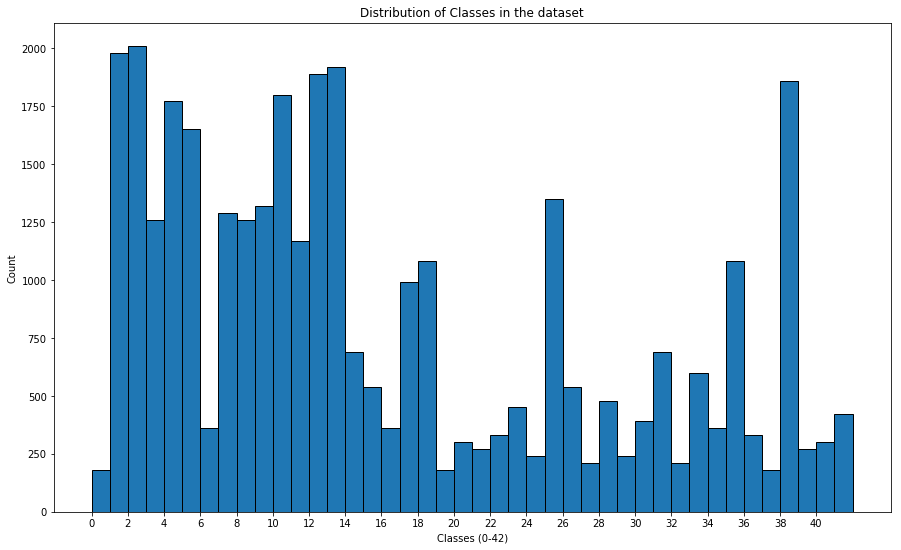

In [5]:
figure = plt.figure(figsize=(15,9))
class_counts = plt.hist(y_train, bins=np.unique(y_train), histtype='bar', edgecolor='black')
plt.xlabel("Classes (0-42)");
plt.ylabel("Count");
plt.xticks([np.unique(y_train)[i] for i in range(0,42,2)]);
plt.title("Distribution of Classes in the dataset");

From the distribution plot it is evident that classes: __"1,2,4,5,10,12,13,38"__ have max number of examples in the dataset. Let's try to see what these classes are.

In [6]:
signnames_dict = {}
with open("signnames.csv") as signs:
    for line in signs.readlines():
        k, v = line.split(',')
        signnames_dict[k] = v

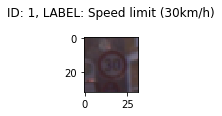

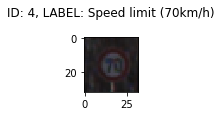

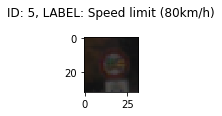

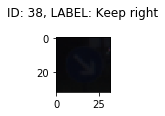

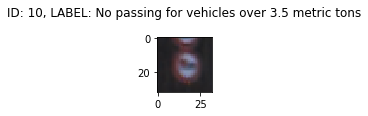

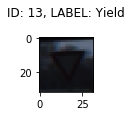

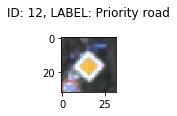

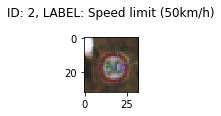

In [7]:
desired_labels = [1,2,4,5,10,12,13,38]
checked = []
for img, label_no in zip(X_train, y_train):
    if label_no in desired_labels and label_no not in checked:
        checked.append(label_no)
        plt.figure(figsize=(1,1))
        plt.imshow(img);
        plt.title("ID: {}, LABEL: {}".format(label_no, signnames_dict[str(label_no)]))

We can infer that, when these images are shown the test set, the model we build later on will have a higher rate of predicting it correctly.

### Pre-process the Data Set (normalization, grayscale, etc.)

The preprocessing steps we are going to follow are listed below <br>
**1. Grayscale conversion** <br>
There are a lot of reasons why images are converted to gray scale in general cases like complexity of writing code for multiple channels, compute power, etc. The one that is applicable to us is that, if we look at the images in the dataset, the color does not seem to make much of difference. For example, a stop sign is a stop sign whether viewed in Black and white or gray or color. Though one may argue that the red color of stop sign makes it visible from a distance, the algorithms we use can view the images perfectly from a distance and without colors. So, for ease of processing, we will be using gray scale images.

**2. Histogram Equalization** <br>
When the images have high contrast, the perception gets better. The histogram equalization technique increases the global contrast of the pixels in the image. Due to this operation, the differences in the pixels are highly visible. For example, an edge might be highlighted better if the contrast is well set.<br>
Since the images in our dataset have a lower resolution, this technique will help us identify the foreground and background pixels better.

**3. Normalization** <br>
Normalization or min-max scaling is a technique by which the values in the image are scaled to a fixed range. In our case we will fit them between 0-1. Typically in a neural network architecture, convergence is faster if the data points follow a similar distribution. <br>
The variance in the data is also reduced by using normalization after the zero-centering. This makes the computations faster as well, thus helping in faster convergence.

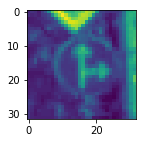

In [8]:
gray = cv2.cvtColor(X_train[1000], cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(2,2))
plt.imshow(gray);

In [9]:
# converts an RGB image to GRAYSCALE
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

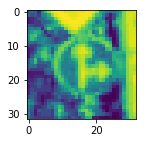

In [10]:
equalized = cv2.equalizeHist(gray)
plt.figure(figsize=(2,2))
plt.imshow(equalized);

In [11]:
# performs histogra equalization
def equalize(img):
    return cv2.equalizeHist(img) # accepts only a gray scale image i.e. depth = 1

In [12]:
def normalize(img):
    return img/255

### Preprocess pipeline

In [13]:
def preprocess(img):
    # convert to gray scale
    img = grayscale(img)
    
    # histogram equalization
    img = equalize(img)
    
    # contrast stretching
    img = normalize(img)
    
    return img

Let's view the result of a preprocessed image.

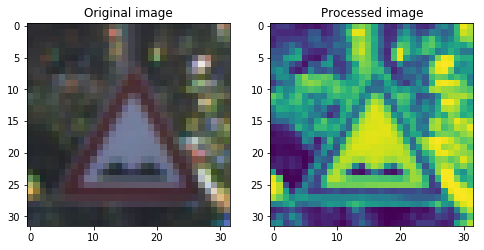

In [14]:
index = random.randint(0,len(X_train))
img = X_train[index]
f, (ax1, ax2) = plt.subplots(1,2,figsize=(8,8))
ax1.imshow(img);
ax1.set_title("Original image");
ax2.imshow(preprocess(img));
ax2.set_title("Processed image");

#### Preprocess all the features in the dataset

In [15]:
X_train = np.array(list(map(preprocess, X_train)))
X_valid = np.array(list(map(preprocess, X_valid)))
X_test = np.array(list(map(preprocess, X_test)))

In [16]:
X_train.shape

(34799, 32, 32)

In [17]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_valid = X_valid.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

#### One Hot Encode the labels

In [18]:
y_train = to_categorical(y_train, 43)
y_valid = to_categorical(y_valid, 43)
y_test = to_categorical(y_test, 43)

----

## Step 2: Design and Test a Model Architecture

Initially, we use a baseline LeNet architecture to check the accuracy on the validation set. <br>
The validation accuracy is around __89%__. By modifying the architecture by tuning the hyperparameters, we will try to achieve a validation accuracy of more than __93%__.

### Model Architecture

#### Setting Hyperparameters

In [19]:
ALPHA = 0.001
EPOCHS = 10
BATCH_SIZE = 128

In [20]:
def LeNet():
    model = Sequential()
    
    # conv 1: total params = 5x5x60+60=1560, output=28x28x60
    model.add(Conv2D(60,(5,5), input_shape=(32,32,1), activation='relu'))
    # conv 2: total params = 5x5x60x60+60=90060, output=24x24x60
    model.add(Conv2D(60, (5, 5), activation='relu'))
    
    # max pool: total params = 0, output=12x12x60 => no change to the depth in pooling layers
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # conv 3: total params = 3x3x30x60+30=16230, output=10x10x30
    model.add(Conv2D(30,(3,3), activation='relu'))
    # conv 4: total params = 3x3x30x30+30=8130, output=8x8x30
    model.add(Conv2D(30,(3,3), activation='relu'))

    # max pool: total params = 0, output=4x4x30
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Flattening: total params = 0, output=4x4x30=480
    model.add(Flatten())
    
    # fully connected 1: total params = 480*500+500=240500, output=500
    model.add(Dense(500, activation='relu'))
    
    # dropout: total params = 0, avoids overfitting
    model.add(Dropout(0.5))
    
    # fully connected 2: total params = 500*43+43=21543, output = 43
    model.add(Dense(n_classes, activation='softmax'))
    
    # compile and return
    model.compile(Adam(lr=ALPHA), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
model = LeNet()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

We can see that our calculation of total_params, matches the numbers in the model summary. Our model is now ready, let's train it on the the training set and see what are the training and validation accuracy.

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [22]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), shuffle=1)
# history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_valid, y_valid), verbose=1, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 10s 285us/step - loss: 1.2734 - acc: 0.6469 - val_loss: 0.2660 - val_acc: 0.9224
Epoch 2/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.1862 - acc: 0.9438 - val_loss: 0.1476 - val_acc: 0.9556
Epoch 3/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.0968 - acc: 0.9701 - val_loss: 0.0983 - val_acc: 0.9696
Epoch 4/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.0673 - acc: 0.9790 - val_loss: 0.1307 - val_acc: 0.9617
Epoch 5/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.0546 - acc: 0.9822 - val_loss: 0.0956 - val_acc: 0.9721
Epoch 6/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.0396 - acc: 0.9877 - val_loss: 0.1174 - val_acc: 0.9732
Epoch 7/10
34799/34799 [==============================] - 8s 237us/step - loss: 0.0340 - acc: 0.9888 - val_loss: 0.0943 - 

We have crossed our goal of reaching a __93%__ accuracy on the validation by a __~5%__ !!!!

Below we can see how the accuracy on the training and validation set increased over epochs. We may draw a conclusion that stopping the training after the 1st epoch would be enough, but several runs and checks on the test set showed that a min of 5-7 epochs showed higher accuracy on the test set.

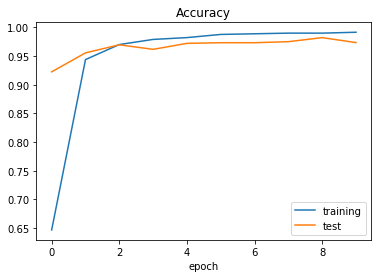

In [23]:
plt.plot(history.history['acc']);
plt.plot(history.history['val_acc']);
plt.legend(['training','test']);
plt.title('Accuracy');
plt.xlabel('epoch');
# plt.yticks(np.linspace(0,1,11));

Below we can see graphs that show how the training and validation losses have reduced over epochs.

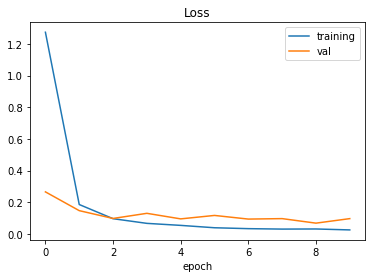

In [24]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['training','val']);
plt.title('Loss');
plt.xlabel('epoch');
# plt.yticks(np.linspace(0,1,5));

Let's evaluate our model on the test set which will be a better measure of our models performance

In [25]:
result = model.evaluate(X_test, y_test, verbose=0)

In [26]:
print('Test Score:', result[0])
print('Test Accuracy:', result[1])

Test Score: 0.228850493364
Test Accuracy: 0.950435471119


#### Finally, below are the results of the model on Train, Validation and Test sets

| Set | Accuracy |
| --- | --- |
| Train | 99.15% |
| Valid | 97.35% |
| Test | 95.04% |

---

## Step 3: Test a Model on New Images

To give ourselves more insight into how the model is working, we downloaded some pictures of German traffic signs from the web and used the model above to check the performance.

### Load and Output the Images

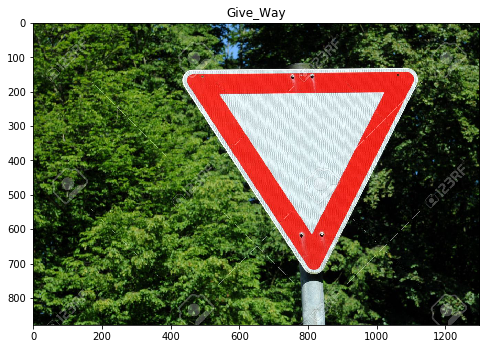

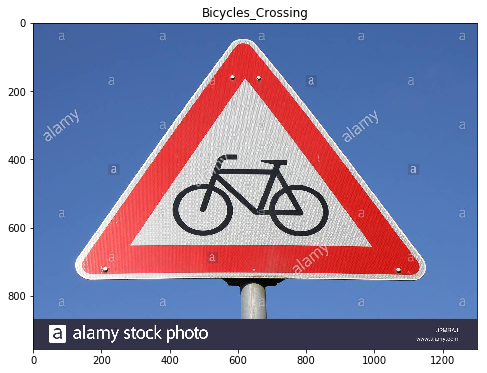

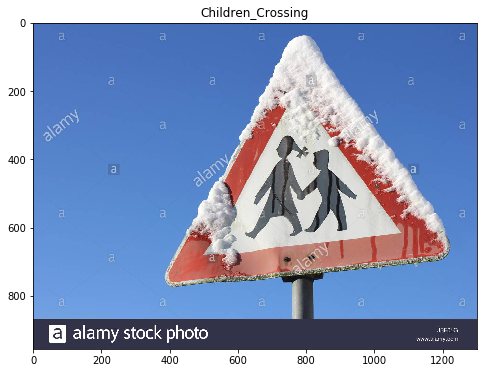

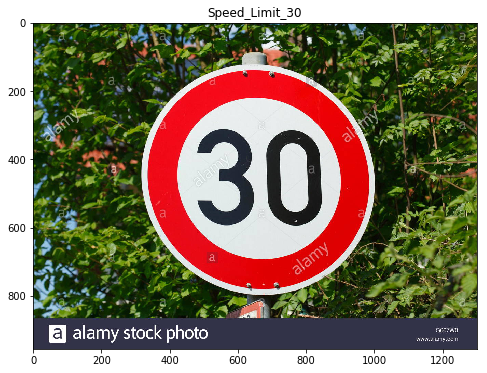

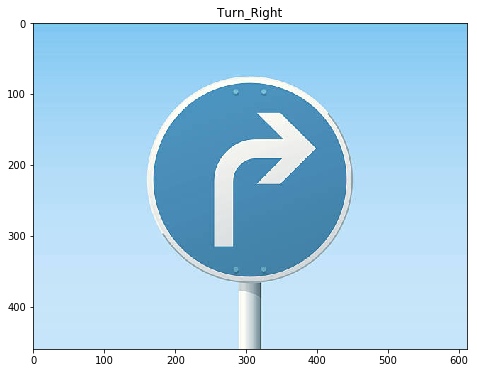

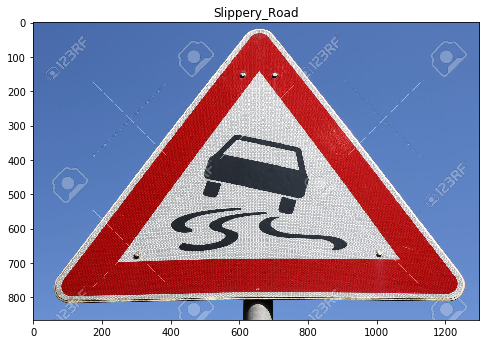

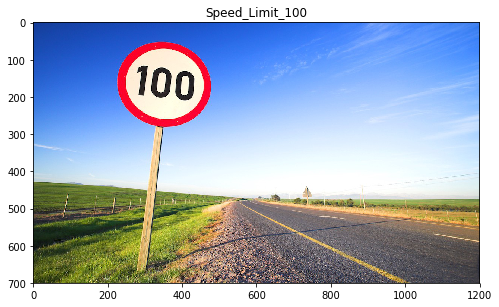

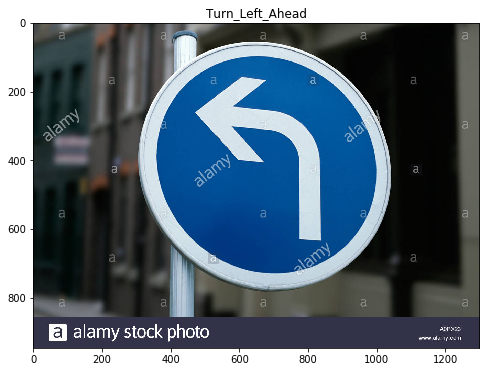

In [27]:
for filepath in glob.glob('external_images/*.jpg'):
    orig_img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6));
    plt.imshow(orig_img);
    plt.title(filepath.split('/')[-1].split('.')[0])

### Predict the Sign Type for Each Image

In [28]:
for filepath in glob.glob('external_images/*.jpg'):
    
    orig_img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(orig_img, (32, 32))
    img = preprocess(img)
    img = img.reshape(1, 32, 32, 1)
    print("The sign is: ",filepath.split('/')[-1].split('.')[0])
    print("predicted sign: ", signnames_dict[str(model.predict_classes(img)[0])])
    print()

The sign is:  Give_Way
1/1 [==============================] - 0s 30ms/step
predicted sign:  Priority road


The sign is:  Bicycles_Crossing
1/1 [==============================] - 0s 4ms/step
predicted sign:  Speed limit (80km/h)


The sign is:  Children_Crossing
1/1 [==============================] - 0s 4ms/step
predicted sign:  Priority road


The sign is:  Speed_Limit_30
1/1 [==============================] - 0s 3ms/step
predicted sign:  Speed limit (30km/h)


The sign is:  Turn_Right
1/1 [==============================] - 0s 3ms/step
predicted sign:  Turn right ahead


The sign is:  Slippery_Road
1/1 [==============================] - 0s 3ms/step
predicted sign:  Slippery road


The sign is:  Speed_Limit_100
1/1 [==============================] - 0s 4ms/step
predicted sign:  Traffic signals


The sign is:  Turn_Left_Ahead
1/1 [==============================] - 0s 4ms/step
predicted sign:  Right-of-way at the next intersection




### Analyze Performance

We can see that our model has an accuracy of 26% on the images that were picked from the web.

Now, it predicted correctly for __Speed limit 30, slippery road and turn right__. <br>

Here are some of the reasons I could think of: <br>
- The bounding boxes when similar create problems in the model being able to predict which class it belongs to.
- I purposefully used an image which had snow on the board and this definitely might have create a problem.
- I also believe that the dataset was not that huge, or I should rephrase saying, "A deep learning model probably might require more examples to learn."

In summary, the model seems to have overfit on our images and we might have to use some other techniques that will provide us with more examples.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [29]:
probabilities = []
images = []
for filepath in glob.glob('external_images/*.jpg'):
    
    orig_img = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(orig_img, (32, 32))
    img = preprocess(img)
    img = img.reshape(1, 32, 32, 1)
    
    images.append(filepath.split('/')[-1].split('.')[0])
    probabilities.append(model.predict_proba(img));

1/1 [==============================] - 0s 3ms/step


In [30]:
count = 0
softmax_final = []
for entry in list(probabilities):
    final_probs = {}
    for index, value in enumerate(entry[0]):
        final_probs[index] = value
    softmax_final.append(dict(sorted(final_probs.items(), key=operator.itemgetter(1), reverse=True)[:5]))

In [31]:
count = 1
for item, image in zip(softmax_final, images):
    print("Image {}: {}".format(count, image))
    print("-------------")
    for key in item.keys():
        print('{} : {}'.format(signnames_dict[str(key)].strip(), item[key]))
    print("-------------")
    count += 1

Image 1: Give_Way
-------------
Priority road : 0.9361149072647095
Yield : 0.042106494307518005
Speed limit (50km/h) : 0.01146041601896286
Ahead only : 0.006828222423791885
No passing for vehicles over 3.5 metric tons : 0.0008564031450077891
-------------
Image 2: Bicycles_Crossing
-------------
Speed limit (80km/h) : 0.6079292297363281
Road work : 0.27933549880981445
Dangerous curve to the left : 0.06612427532672882
Wild animals crossing : 0.01839737966656685
No passing for vehicles over 3.5 metric tons : 0.011532790027558804
-------------
Image 3: Children_Crossing
-------------
Priority road : 0.9970569610595703
Right-of-way at the next intersection : 0.002387598855420947
Roundabout mandatory : 0.000504632480442524
Speed limit (50km/h) : 2.4812457922962494e-05
Speed limit (80km/h) : 4.578428615786834e-06
-------------
Image 4: Speed_Limit_30
-------------
Speed limit (30km/h) : 0.9980493783950806
Speed limit (80km/h) : 0.0018244765233248472
Speed limit (70km/h) : 5.744009104091674e-

### Discussion about the certainity of the Model

Let's discuss the images one by one <br>
1. __Give way__ <br>
We can see that the model hasn't been able to identify the image correctly and none of the top 5 probabilities match that of the original label
2. __Bicycles Crossing__ <br>
Though the prediction is incorrect and the top 5 probabilitie listed do not match the original label, we can see another form of crossing i.e. Wild animal crossing making its way in the top 5 though the probability is negligible. There are still signs of promise :)
3. __Children Crossing__ <br>
The prediction is incorrect
4. __Speed Limit 30__ <br>
The prediction is correct and all the top 5 probabilities relate to the speed limit sign. This is really cool and the model is not a complete failure it seems :))
5. __Turn Right__ <br>
The prediction is correct again. An interesting observation is that __Keep left__ makes it to the top of probability list. The model needs to learn to distinguish between __left__ and __right__
6. __Slippery Road__ <br>
Correct prediction
7. __Speed Limit 100__ <br>
Incorrect prediction. However, __Speed limit 120__ makes it to the list of top 5
8. __Turn left__ <br>
As we discussed before, we can see that the model is not probably not able to distinguish between left and right. There is a chance for improvement.

<hr>

## End of notebook, optional section of visualizing the intermediate layers ommitted for now.

<hr>